## IMPORTACIÓN DE LIBRERIAS NECESARIAS ##

In [1]:
import zipfile

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from datetime import datetime 
from collections import Counter

%matplotlib inline

## EXTRACCIÓN/CARGA DE DATOS 

In [2]:
# Asignamos a una variable la ruta donde se encuentra el archivo zip con el dataset que vamos a trabjar
# Asignamos a otra variable el directorio donde queremos que guarde el dataset extraido de ese archivo zip

path_to_zip_file = '../data/dataset_shark_attack.zip'
directory_to_extract_to = '../data'

In [23]:
# Con esta función de esta libreria importada extraemos el contenido en el zip y lo guardamos en el dorecotrio antes asignado

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [3]:
# Asiganmos a una nueva variable el contenido del dataset, en este caso un archivo csv
# Guardamos en otra variable los datos decodificados con una función de pandas para empezar a trabjar con ellos en python

path_dataset = '/Users/antoineambros/Documents/proyectos/shark_attacks/data/attacks.csv'
data = pd.read_csv(path_dataset, encoding='latin1')

## EXPLORACIÓN DE DATOS

### Conocer información básica

In [9]:
print('Cantidad de Filas y columnas:',data.shape)

Cantidad de Filas y columnas: (25723, 24)


In [10]:
print(f'COLUMNAS DEL DATASET: {data.columns.values}')

COLUMNAS DEL DATASET: ['Case Number' 'Date' 'Year' 'Type' 'Country' 'Area' 'Location' 'Activity'
 'Name' 'Sex' 'Age' 'Injury' 'Fatal' 'Time' 'Species'
 'Investigator or Source' 'pdf' 'href formula' 'href' 'Case Number.1'
 'Case Number.2' 'original order' 'Unnamed: 22' 'Unnamed: 23']


In [ ]:
# Veamos el tipo de datos. Un vistazo preliminar del contenido del dataset

data.head()

In [5]:
# Aqui podremos ver los tipos de datos que vamos a manejar, si hay muchos datos 'nulos' en el dataset

data.info()

In [4]:
data.isnull().sum()

#### Con la siguiente función vamos a ver cómo son los datos de los que se componen cada una de las variables que tenemos en el DataSet

In [5]:
for i in data.columns:
    print(str(i) + ':' + str(data[i].unique()) + '\n' )

In [6]:
# Mediante esta función podemos ver datos aleatorios de nuestra estructura, y hacernos una idea de lo que tenemos

data.sample(3)

##### Aqui si nos fijamos bien, no todas las columnas están bien escritas, o no aportan nada porque solamente contienen valores NaN, como en el caso de "Unnamed: 22" y "Unnamed: 23",  y eso nos puede llevar a errores mas adelante. Así que vamos a mofificar y eliminar las variables que no nos vayan a hacer falta o no aporten ningún valor al estudio.

In [256]:
# Tenemos dos columnas con un espacio al final y otra con paréntesis, mayúsculas... Vamos a renombrarlas

print('Nombre columnas:',data.columns)

### Arreglamos eso:

In [4]:
data.rename(columns = {'Sex ':'Sex'}, inplace = True)
data.rename(columns = {'Species ':'Species'}, inplace = True)
data.rename(columns = {'Fatal (Y/N)':'Fatal'}, inplace = True)

## Ahora comprobamos los países donde se dan mas casos de ataques de tiburones. El Top 5.

In [6]:
country = data['Country']
Counter(country).most_common(6)

[(nan, 19471),
 ('USA', 2229),
 ('AUSTRALIA', 1338),
 ('SOUTH AFRICA', 579),
 ('PAPUA NEW GUINEA', 134),
 ('NEW ZEALAND', 128)]

In [7]:
country = country.dropna()
top_country = dict(Counter(country).most_common(5))
y_count= (top_country.keys())
x_count= top_country.values()
y_pos_count = np.arange(len(y_count))

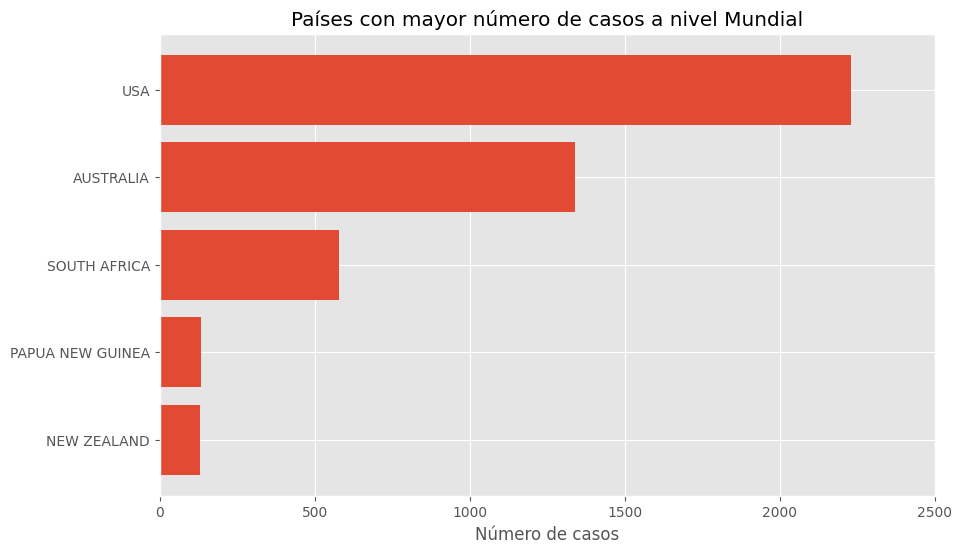

In [8]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10, 6]
fig, ax = plt.subplots()
ax.barh(y_pos_count, x_count, align='center')
ax.set_yticks(y_pos_count)
ax.set_yticklabels(y_count)
ax.invert_yaxis()  
ax.set_xlabel('Número de casos')
ax.set(xlim=[0, 2500])
ax.set_title('Países con mayor número de casos a nivel Mundial');

### El País que vamor a centrar nuestro análisis exploratorio será USA

In [8]:
# Vamos a filtrar el dataset por el país con el que nos vamos a quedar para el análisis

country = 'USA'
df_country_filtered = data[data['Country'] == country]

count_num_country_filtered = len(df_country_filtered)
print(f'Los número de registros de ataques de tiburón en {country} son {count_num_country_filtered}')

Los número de registros de ataques de tiburón en USA son 2229


## **Preprocesamiento de datos**

#### Primero vamos a eliminar las variables con las que no vamos a trabajar. Ya sea porque no aportan nada, o porque sólo tienen valores nulos, ect...

##### Borramos las columnas que no nos interesan para el estudio, haciendo una copia para que no perder es dataset original

In [9]:
data_USA = df_country_filtered.copy()

drop_columns = ['Unnamed: 22',
         'Unnamed: 23',
         'Case Number',
         'Name',
         'Investigator or Source',
         'pdf',
         'href formula',
         'href',
         'Case Number.1',
         'Case Number.2',
         'Injury',
         'original order',
         'Time',
         'Location',
         'Area',
         'Type']
         

data_USA.drop(drop_columns, axis=1, inplace=True)

In [37]:
print(f'LAS COLUMNAS QUE AHORA NOS QUEDAN SON: {data_USA.columns}')

LAS COLUMNAS QUE AHORA NOS QUEDAN SON: Index(['Date', 'Year', 'Country', 'Activity', 'Sex', 'Age', 'Fatal',
       'Species'],
      dtype='object')


In [16]:
for i in data_USA.columns:
     print(str(i) + ':' + str(data_USA[i].unique()) + '\n' )

## Limpieza de Nulos

In [10]:
# Aqui vamos ha hacer un conteo de datos nulos en el nuevo dataset con los datos filtrados por el país elegido. USA

data_USA.isnull().sum()

Date          0
Year          0
Country       0
Activity    134
Sex          98
Age         727
Fatal       188
Species     906
dtype: int64

### Vamos a crear una función que nos permita visualizar las columnas que contienen más datos nulos mediante una gráfica

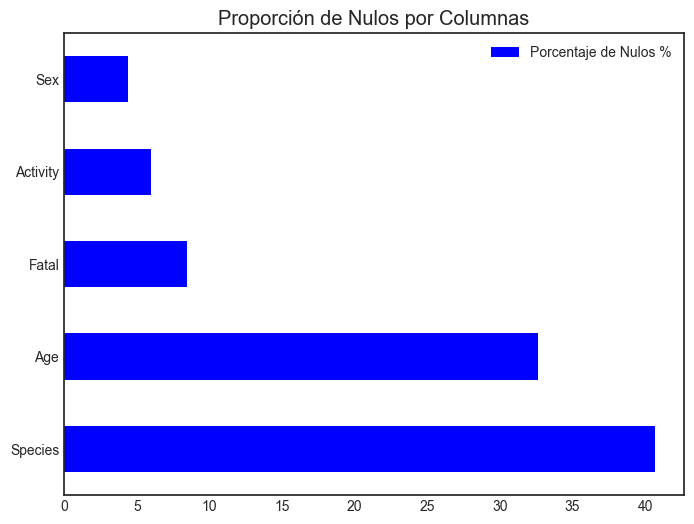

In [39]:
plt.style.use("seaborn-white")

def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Porcentaje de Nulos %' :na_df})
        missing_data.plot(kind = "barh", title="Proporción de Nulos por Columnas", color='blue', alpha=1., figsize=(8, 6))
        plt.show()
    else:
        print('No Nas found')
plot_nas(data_USA)

#### Ahora vamos a proceder a rellenar esos valores nulos o missing que contienen las variables visualizadas y modificar algunas variables cambiándole el tipo a numérico para poder trabajarlas

In [66]:
data_USA.dtypes

Date         object
Year          int64
Country      object
Activity     object
Sex          object
Age         float64
Fatal        object
Species      object
dtype: object

### Comenzamos con la variable "Date"

In [11]:
def date_convert(date):
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    num_months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
    
    date = str(date)
    if (len(date) == 11 and date[2] == '-'):
        for i in range(len(months)):
            date = date.replace(months[i], num_months[i])
        return date
    else:
        return np.nan

In [12]:
data_USA['Date'] = data_USA['Date'].apply(date_convert)

In [13]:
data_USA = data_USA[~data_USA['Date'].isna()]

### Variable "Year"

In [14]:
def year_covert(year):
    if year > 1945.0: 
        return year
    else:
        return np.nan

In [15]:
data_USA['Year'] = data_USA['Year'].apply(year_covert)

In [16]:
data_USA = data_USA[~data_USA['Year'].isna()]

In [17]:
data_USA = data_USA.astype({'Year':'int'})

### Variable "Sex"

In [18]:
def sex_covert(sex):
    if sex == 'M' or sex == 'F':
        return sex
    else:
        return np.nan

In [19]:
data_USA['Sex'] = data_USA['Sex'].apply(sex_covert)

In [20]:
data_USA[['Sex']].mode()

,Sex
0,M


In [20]:
data_USA['Sex'].fillna('M', inplace=True)

### Variable "Age"

In [21]:
def age_covert(age):
    try:
        age = int(age)
    except ValueError:
        age = 0
        
    if (age > 0 and age <= 100):
        return age
    else:
        return np.nan

In [22]:
data_USA['Age'].fillna(0, inplace=True)

In [23]:
data_USA['Age'] = data_USA['Age'].apply(age_covert)

In [24]:
data_USA = data_USA[~data_USA['Age'].isna()]

In [25]:
data_USA = data_USA.astype({'Age':'int'})

### Variable "Fatal"

In [26]:
data_USA = data_USA.replace({'Fatal':{' N':'N','N ':'N'}})

In [27]:
def fatal_convert(fatal):
    if fatal == 'N' or fatal == 'Y':
        return fatal
    else:
        return np.nan

In [28]:
data_USA['Fatal'] = data_USA['Fatal'].apply(fatal_convert)

In [45]:
data_USA[['Fatal']].mode()

,Fatal
0,N


In [29]:
data_USA['Fatal'].fillna('N', inplace=True)

### Variable "Activity"

In [87]:
print(data_USA['Activity'].value_counts())

Surfing                                                      524
Swimming                                                     219
Wading                                                        92
Fishing                                                       56
Standing                                                      46
                                                            ... 
Wading in school of baitfish                                   1
Swimming with dolphins                                         1
Lying prone in 2' of water                                     1
Wading with surfboard                                          1
C47 aircraft carrying 5,000 lbs of ice ditched in the sea      1
Name: Activity, Length: 366, dtype: int64


In [30]:
data_USA.loc[data_USA['Activity'].str.contains('surf', case=False, na=False), 'Activity'] = 'Surfing'
data_USA.loc[data_USA['Activity'].str.contains('boarding', case=False, na=False), 'Activity'] = 'Surfing'
data_USA.loc[data_USA['Activity'].str.contains('swim', case=False, na=False), 'Activity'] = 'Swimming'
data_USA.loc[data_USA['Activity'].str.contains('fishing', case=False, na=False), 'Activity'] = 'Fishing'
data_USA.loc[data_USA['Activity'].str.contains('aquarium', case=False, na=False), 'Activity'] = 'Fishing'
data_USA.loc[data_USA['Activity'].str.contains('hunt', case=False, na=False), 'Activity'] = 'Fishing'
data_USA.loc[data_USA['Activity'].str.contains('trap', case=False, na=False), 'Activity'] = 'Fishing'
data_USA.loc[data_USA['Activity'].str.contains('walk', case=False, na=False), 'Activity'] = 'Swimming'
data_USA.loc[data_USA['Activity'].str.contains('wading', case=False, na=False), 'Activity'] = 'Swimming'
data_USA.loc[data_USA['Activity'].str.contains('float', case=False, na=False), 'Activity'] = 'Swimming'
data_USA.loc[data_USA['Activity'].str.contains('Treading water', case=False, na=False), 'Activity'] = 'Swimming'
data_USA.loc[data_USA['Activity'].str.contains('pull', case=False, na=False), 'Activity'] = 'Fishing'
data_USA.loc[data_USA['Activity'].str.contains('pick', case=False, na=False), 'Activity'] = 'Fishing'
data_USA.loc[data_USA['Activity'].str.contains('bath', case=False, na=False), 'Activity'] = 'Swimming'
data_USA.loc[data_USA['Activity'].str.contains('diving', case=False, na=False), 'Activity'] = 'Diving'
data_USA.loc[data_USA['Activity'].str.contains('snorkel', case=False, na=False), 'Activity'] = 'Diving'

In [31]:
data_USA['Activity'].value_counts().head(10)

Surfing                    620
Swimming                   340
Fishing                    114
Diving                      86
Standing                    43
Kayaking                    11
Playing                      6
Jumping                      4
Escaping from Alacatraz      3
Clamming                     2
Name: Activity, dtype: int64

In [32]:
def activity_convert(activity):
    if activity == 'Surfing' or activity == 'Swimming' or activity == 'Fishing' or activity == 'Diving' or activity == 'Standing' or activity == 'Kayaking' or activity == 'Playing' or activity == 'Jumping' or activity == 'Tagging sharks' or activity == 'Canoeing':
        return activity
    else:
        return np.nan

In [33]:
data_USA['Activity'] = data_USA['Activity'].apply(activity_convert)

In [34]:
data_USA['Activity'].fillna('Fishing', inplace=True)

### Variable "Species"

In [44]:
data_USA['Species'].value_counts().head(6)

White shark       1215
Tiger shark         63
Bull shark          43
Blacktip shark       7
Nurse shark          5
Name: Species, dtype: int64

In [37]:
def species_convert(species):
    if species == 'Nurse shark' or species == 'White shark' or species == 'Tiger shark' or species == 'Shark involvement not confirmed' or species == 'Blacktip shark' or species == 'Bull shark' or species == "4' shark" or species == "6' shark":
        return species
    else:
        return np.nan

In [38]:
data_USA['Species'] = data_USA['Species'].apply(species_convert)

In [43]:
data_USA['Species'].fillna('White shark', inplace=True)

In [41]:
data_USA = data_USA.replace({'Species':{"4' shark":'Tiger shark'}})
data_USA = data_USA.replace({'Species':{"Shark involvement not confirmed":'Bull shark'}})
data_USA = data_USA.replace({'Species':{"6' shark":'Tiger shark'}})

### Ahora podemos comprobar como hemos limpiado los datos de cada una de las columnas, y nos hemos quedado sin ningún valor nulo en todas ellas

In [45]:
data_USA

,Date,Year,Country,Activity,Sex,Age,Fatal,Species
0,25-06-2018,2018,USA,Fishing,F,57,N,White shark
1,18-06-2018,2018,USA,Standing,F,11,N,White shark
2,09-06-2018,2018,USA,Surfing,M,48,N,White shark
7,27-05-2018,2018,USA,Fishing,M,52,N,White shark
8,26-05-2018,2018,USA,Swimming,M,15,N,White shark
...,...,...,...,...,...,...,...,...
4509,25-07-1949,1949,USA,Swimming,M,16,N,White shark
4510,16-07-1949,1949,USA,Fishing,M,16,N,White shark
4545,01-07-1948,1948,USA,Swimming,M,46,Y,White shark
4570,04-08-1947,1947,USA,Swimming,M,20,Y,White shark


In [46]:
data_USA.isnull().sum()

Date        0
Year        0
Country     0
Activity    0
Sex         0
Age         0
Fatal       0
Species     0
dtype: int64

### Creamos nuestro nuevo DataFrame reseteando los índices, para tenerlo ya con las columnas seleccionadas para nuestro estudio. Ahora ya están filtradas, limpias y corregidos errorer

In [47]:
data_USA = data_USA.reset_index()
data_USA.drop(['index'], axis=1 , inplace=True)

In [48]:
data_USA.isnull().sum()

Date        0
Year        0
Country     0
Activity    0
Sex         0
Age         0
Fatal       0
Species     0
dtype: int64

In [49]:
data_USA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1333 entries, 0 to 1332
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      1333 non-null   object
 1   Year      1333 non-null   int64 
 2   Country   1333 non-null   object
 3   Activity  1333 non-null   object
 4   Sex       1333 non-null   object
 5   Age       1333 non-null   int64 
 6   Fatal     1333 non-null   object
 7   Species   1333 non-null   object
dtypes: int64(2), object(6)
memory usage: 83.4+ KB


In [50]:
data_USA

,Date,Year,Country,Activity,Sex,Age,Fatal,Species
0,25-06-2018,2018,USA,Fishing,F,57,N,White shark
1,18-06-2018,2018,USA,Standing,F,11,N,White shark
2,09-06-2018,2018,USA,Surfing,M,48,N,White shark
3,27-05-2018,2018,USA,Fishing,M,52,N,White shark
4,26-05-2018,2018,USA,Swimming,M,15,N,White shark
...,...,...,...,...,...,...,...,...
1328,25-07-1949,1949,USA,Swimming,M,16,N,White shark
1329,16-07-1949,1949,USA,Fishing,M,16,N,White shark
1330,01-07-1948,1948,USA,Swimming,M,46,Y,White shark
1331,04-08-1947,1947,USA,Swimming,M,20,Y,White shark


### **En este gráfico se muestra la cantidad de ataques de tuburones en USA desde 1945 hasta 2018.**

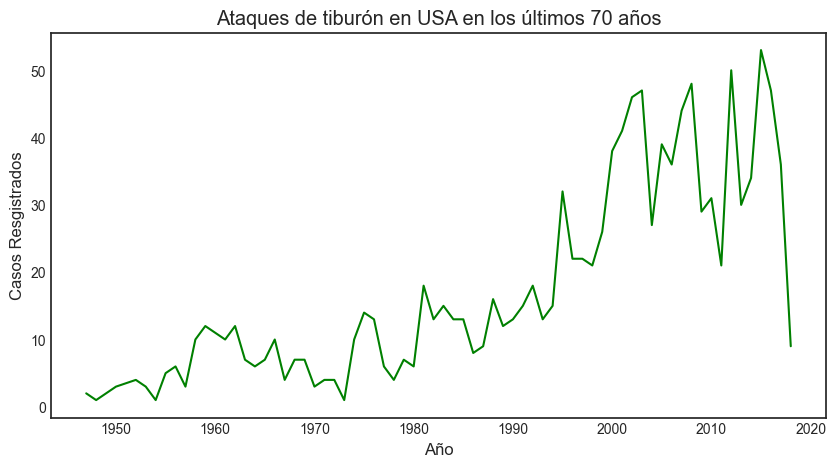

In [74]:
year_attack = data_USA[data_USA['Year'] >= 1945]

year_attack = year_attack.groupby('Year')['Date'].count().reset_index()

plt.style.use("seaborn-white")
year_attack.plot(kind='line', x= "Year", y= "Date", title= "Ataques de tiburón en USA en los últimos 70 años", legend=False, linestyle='-', color='g', figsize=(10, 5))
plt.xlabel('Año')
plt.ylabel('Casos Resgistrados')

plt.show();

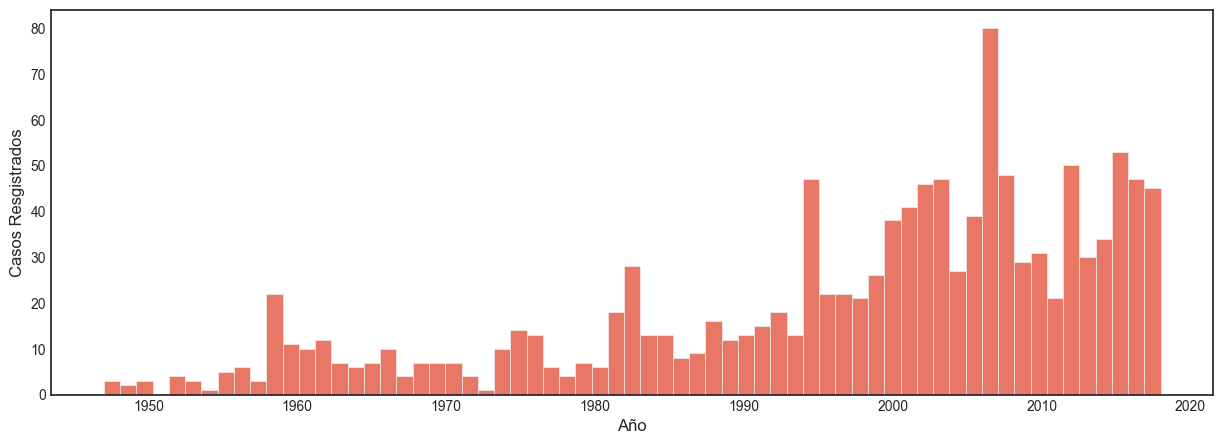

In [75]:
plt.figure(figsize = (15,5))
sns.histplot(data=data_USA, x="Year", bins=65)
plt.xlabel('Año')
plt.ylabel('Casos Resgistrados')
plt.show();

### **Aqui vamos a mostrar los ataques registrados en USA entre 2002 y 2018, siendo este último año, del último que se tienen registros**

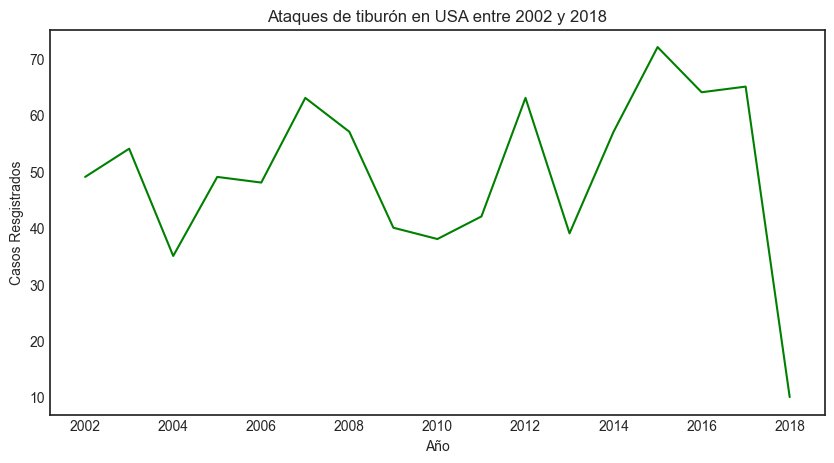

In [117]:
year_attack2 = data_USA[data_USA['Year'] >= 2002]

year_attack2 = year_attack2.groupby('Year')['Date'].count().reset_index()
plt.style.use("seaborn-white")
year_attack2.plot(kind='line', x= "Year", y= "Date", title= "Ataques de tiburón en USA entre 2002 y 2018", legend=False, linestyle='-', color='g', figsize=(10, 5))
plt.xlabel('Año')
plt.ylabel('Casos Resgistrados')

plt.show();

### **TOP TEN AÑOS CON MÁS ATAQUES**

In [122]:
dates = pd.to_datetime(data_USA['Date'],dayfirst=True, errors='coerce')

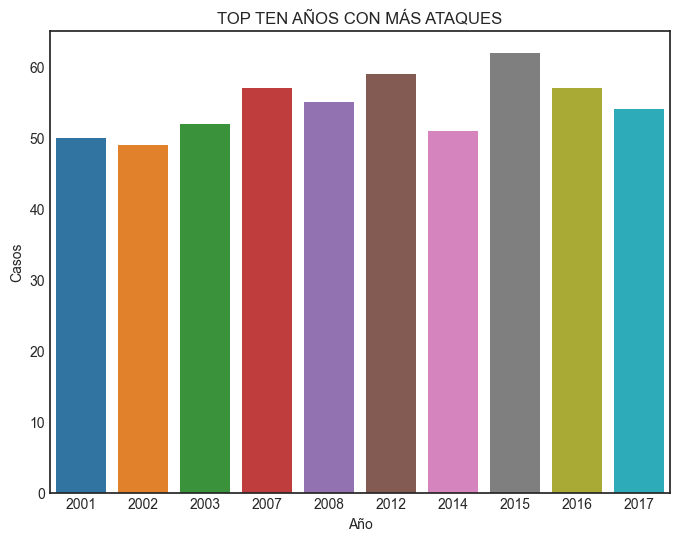

In [127]:
year = dates.dropna().map(lambda x:x.year)
year_counter = Counter(year).most_common(10)
year_index = [year[0] for year in year_counter]
year_values = [year[1] for year in year_counter]

fig,ax = plt.subplots(figsize=(8,6))
sns.barplot(x = year_index,y=year_values,ax=ax)
plt.title('TOP TEN AÑOS CON MÁS ATAQUES')
plt.xlabel('Año')
plt.ylabel('Casos')
plt.show();

### **Proporción de Víctimas según Sexo y Año**

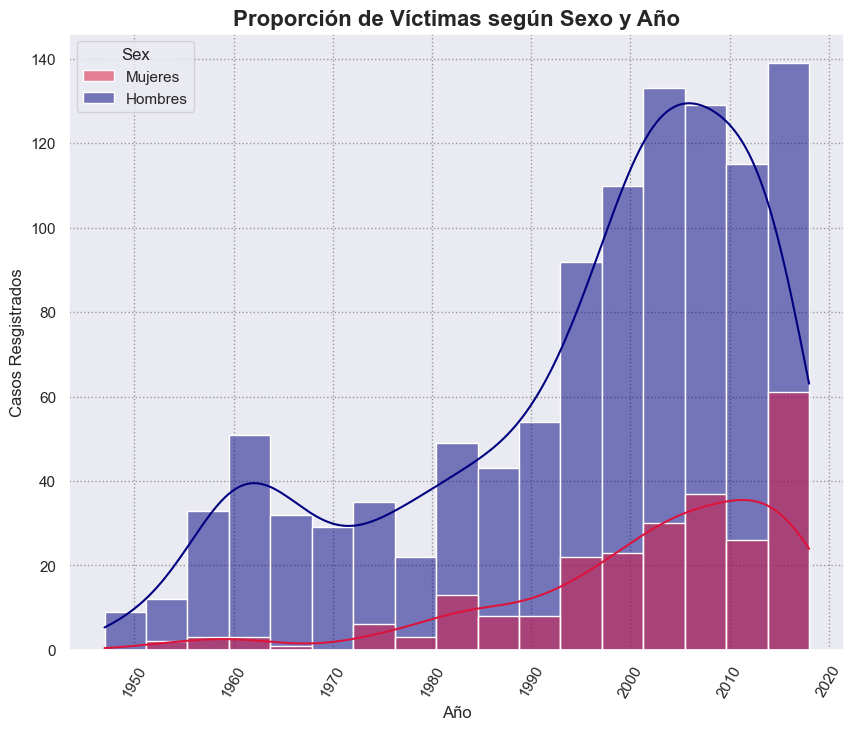

In [104]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
fig, ax = plt.subplots(figsize=(10, 8))
sns.histplot(data=data_USA, x="Year", kde=True, hue="Sex", palette=["crimson", "navy"], alpha=0.5, ax=ax)
plt.xticks(rotation=60)
plt.xlabel('Año')
plt.ylabel('Casos Resgistrados')
plt.title('Proporción de Víctimas según Sexo y Año', fontsize=16, fontweight='bold')
plt.plot();

### **Proporción de Víctimas por Edad**

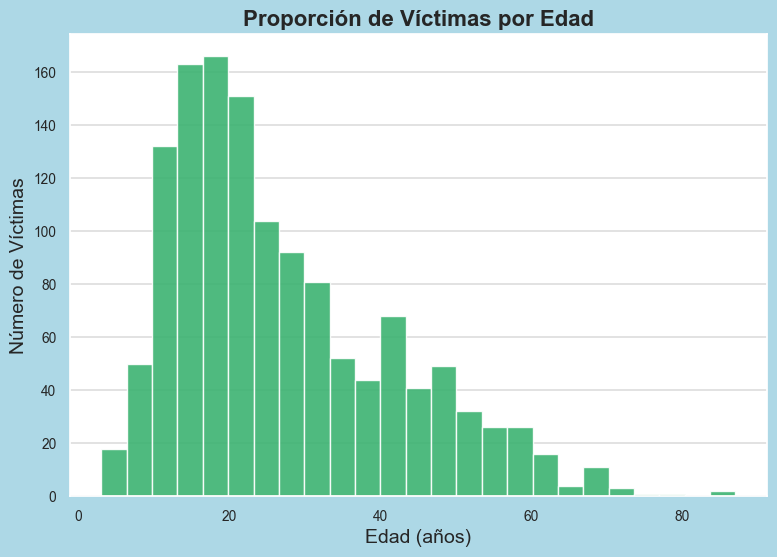

In [64]:
sns.set(rc={'axes.facecolor':'w', 'figure.facecolor':'lightblue'}, font_scale=0.9)
data_USA['Age'].plot(kind='hist', figsize=(9, 6), alpha=0.9, bins=25, color='mediumseagreen')
plt.xlabel('Edad (años)', fontsize=14)
plt.ylabel('Número de Víctimas', fontsize=14)
plt.title('Proporción de Víctimas por Edad', fontsize=16, fontweight='bold')
plt.grid(color='k', axis='y', alpha=0.6, lw=0.3)
data_USA.Fatal.value_counts()
plt.show();

### **Proporción de Víctimas teniendo en cuenta la edad y el sexo**

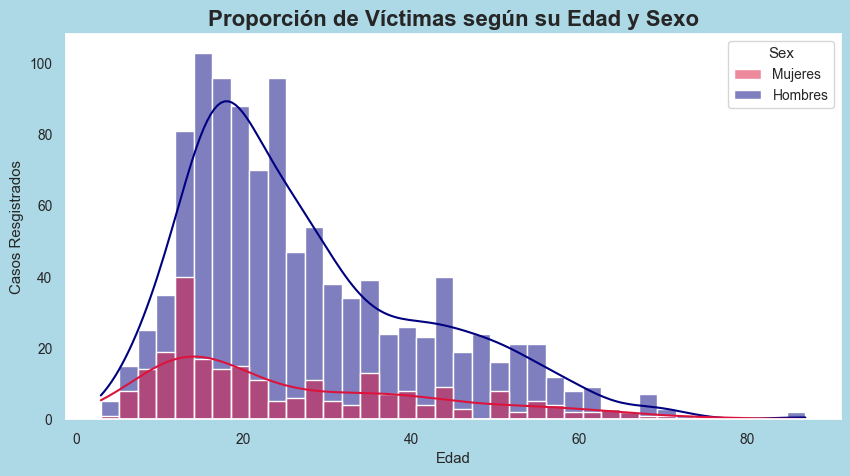

In [62]:
plt.figure(figsize = (10,5))
sns.histplot(data=data_USA, x="Age", kde=True, hue="Sex", palette=["crimson", "navy"], alpha=0.5, bins=38)
plt.xlabel('Edad')
plt.ylabel('Casos Resgistrados')
plt.title('Proporción de Víctimas según su Edad y Sexo', fontsize=16, fontweight='bold')
plt.plot();

## Visualización de ataques de tiburón en USA según el género

In [53]:
data_USA['Sex'].value_counts()

M    1087
F     246
Name: Sex, dtype: int64

In [54]:
data_USA.loc[data_USA['Sex'].str.contains("M"), 'Sex'] = "Hombres"

In [55]:
data_USA.loc[data_USA['Sex'].str.contains("F"), 'Sex'] = "Mujeres"

In [56]:
Sex_count = data_USA['Sex'].value_counts().reset_index().rename(columns={'index':'Gender','Sex':'Count'})

Sex_count

,Gender,Count
0,Hombres,1087
1,Mujeres,246


### **Gráfica sobre la Propoción de casos de ataques de tiburones en Hombres y Mujeres en USA**

In [65]:
fig = px.pie(data_frame = Sex_count,
             values = 'Count',
             names = 'Gender',
             title = 'Ataques de Tiburón por Género en USA',
             color_discrete_sequence=px.colors.qualitative.Set2
             )

In [66]:
fig.update_traces(textposition ='outside',
                  textinfo = 'label+percent')
fig.update_layout(paper_bgcolor='moccasin',
                  legend_title = 'Género',
                  font = dict(
                      family = "Helvetica",
                      size = 18,
                      color = 'black'
                  ))

fig.show();

### **Vamos a mostrar ahora las proporciones de muertes y de supervivientes a los ataques por tiburones en USA**

In [67]:
data_USA['Fatal'].value_counts()

N    1279
Y      54
Name: Fatal, dtype: int64

In [68]:
data_USA.loc[data_USA['Fatal'] == "N", 'Fatal'] = 'NO'

In [69]:
data_USA.loc[data_USA['Fatal'] == "Y", 'Fatal'] = 'SI'

In [70]:
Fatal_count = data_USA['Fatal'].value_counts().reset_index().rename(columns = {'Fatal':'Count','index':'Status'})
Fatal_count

,Status,Count
0,NO,1279
1,SI,54


In [89]:
fig2 = px.pie(data_frame = Fatal_count,
             values = 'Count',
             names = 'Status',
             title = 'Porcentaje de Mortalidad',
             color_discrete_sequence=px.colors.qualitative.Set2
             )

In [90]:
fig2.update_traces(textposition ='outside',
                  textinfo = 'label+percent')
fig2.update_layout(paper_bgcolor='navajowhite',
                  legend_title = '¿MURIÓ?',
                  font = dict(
                      family = "Helvetica",
                      size = 18,
                      color = 'black'
                  ))

fig2.show();

### **Aquí vamos a ver de forma gráfica el TOP 5 de los tiburones que más ataques han provocado en USA**

In [97]:
data_USA['Species'].value_counts()

White shark       1215
Tiger shark         63
Bull shark          43
Blacktip shark       7
Nurse shark          5
Name: Species, dtype: int64

In [99]:
shark5 = data_USA.groupby(['Species'], as_index=False).size()

shark5 = shark5.sort_values(by=['size'], ascending=False)

shark5 = shark5[0:5]

mlabels=['White shark','Tiger shark','Bull shark','Bronze whaler shark', 'Nurse shark']

plt.pie(shark5['size'],labels=mlabels, explode = (0.1,0.1,0.1,0.1,0.1), autopct='%1.1f%%')

plt.title('Top 5 de los Tiburones más Peligrosos en USA', loc='center')

fig = plt.gcf()

fig.set_size_inches(8,6)

plt.legend(bbox_to_anchor=(1,0.6), loc="lower left")

plt.show();
                          

### **Top 6 actividades más expuestas a un ataque de tiburón**

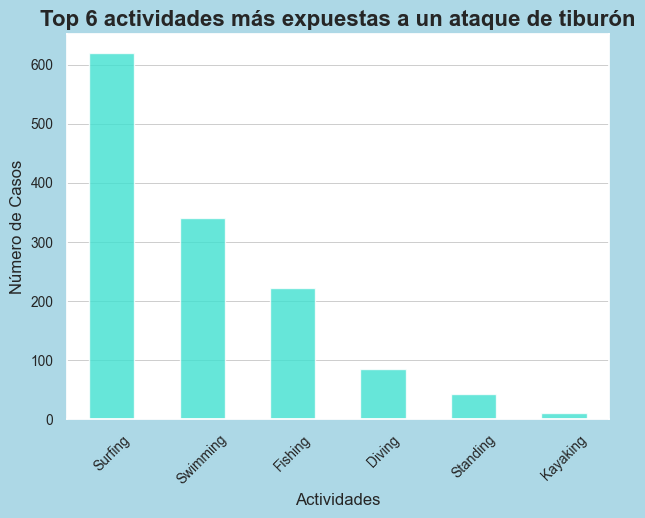

In [123]:
activity = data_USA.Activity.value_counts().head(6)

sns.set(rc={'axes.facecolor':'w', 'figure.facecolor':'lightblue'}, font_scale=0.9)
activity.plot(kind='bar', figsize=(7, 5), alpha=0.8, color='turquoise', rot=45)
plt.xlabel('Actividades', fontsize=12)
plt.ylabel('Número de Casos', fontsize=12)
plt.title('Top 6 actividades más expuestas a un ataque de tiburón', fontsize=16, fontweight='bold')
plt.grid(color='k', axis='y', alpha=0.3, lw=0.5)
plt.show();

### **Proporción de víctimas por sexo y actividad realizada**

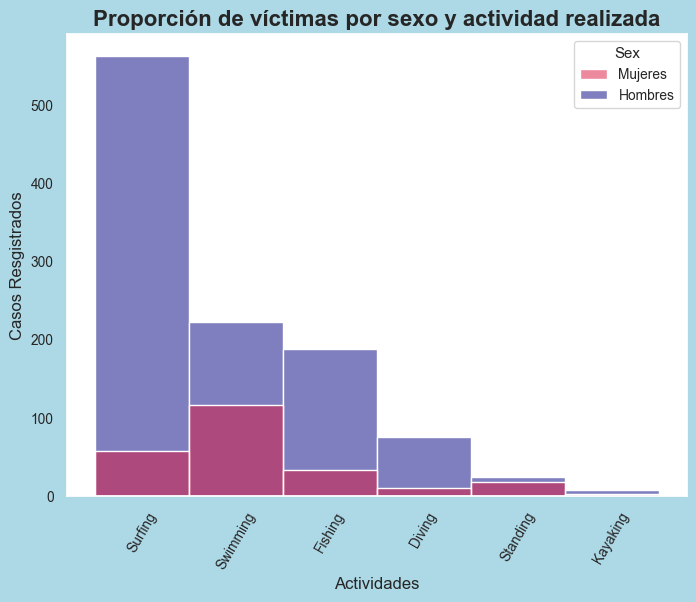

In [134]:
activity_count = data_USA["Activity"].value_counts()[:6].index.to_list()
activities = pd.Categorical(data_USA['Activity'], activity_count)

plt.figure(figsize = (8, 6))
sns.histplot(data=data_USA, x=activities, hue="Sex", palette=["crimson", "navy"], alpha=0.5)
plt.xlabel('Actividades', fontsize=12)
plt.ylabel('Casos Resgistrados', fontsize=12)
plt.title('Proporción de víctimas por sexo y actividad realizada', fontsize=16, fontweight='bold')
plt.xticks(rotation=60)
plt.plot();

### **Estacionalidad en los ataques de tiburón**

In [138]:
dates = pd.to_datetime(data_USA['Date'], dayfirst=True, errors='coerce')

In [149]:
months = dates.dropna().map(lambda x: x.month)

def get_season(month):
    if month >= 3 and month <= 5:
        return 'Spring'
    elif month >= 6 and month <= 8:
        return 'Summer'
    elif month >= 9 and month <= 11:
        return 'Autumn'
    else:
        return 'Winter'

months_labels = months.apply(get_season)

months_counter = Counter(months_labels)
months_keys = list(months_counter.keys())
months_values = list(months_counter.values())

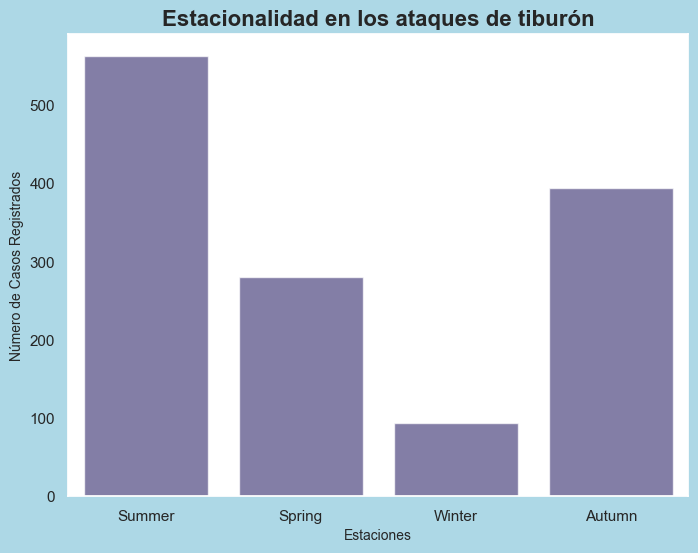

In [168]:
fig = plt.subplots(figsize=(8, 6))
sns.set(rc={'axes.facecolor':'w', 'figure.facecolor':'lightblue'})
sns.barplot(x=months_keys, y=months_values, alpha=0.7, color='darkslateblue')
plt.xlabel('Estaciones', fontsize=10)
plt.ylabel('Número de Casos Registrados', fontsize=10)
plt.title('Estacionalidad en los ataques de tiburón', fontsize=16, fontweight='bold')
plt.show();

## **CONCLUSIONES:**

Podemos decir que el número de accidentes con tiburones tiende a ser mayor cada año desde la década de 1980. Esto podría deberse a dos factores pricipalmente. El primero, que se están reportando y registrando más casos desde entonces, ya que la tecnología, la comunicación, la seguridad marítima, ect, es mucho mayor. Y la segunda, porque los tiburones y los humanos cada vez viven más cerca, el ser humano no deja de invadir todo espacio natural y consigo invaden hábitats salvajes dónde hay fauna salvaje.

También podemos decir que la mayoría de los ataques ocurren realizando actividades como el Surf, la Natación y la Pesca. Aunque el más peligroso es claramente el surf. 
Estos accidentes se producen en un 81,5% en hombres frente al 18,5% en las mujeres. Podemos suponer que este tipo de actividades, sobretodo la pesca, han sido realizadas siempre por hombres, y hasta hace unas pocas décadas el surf, la natación en aguas abiertas o el buceo eran tambien actividades donde predominaba el hombre. Esta tendencia ha ido cambiando, y así lo demuestran los datos que hemos podido analizar y visualizar, donde se puede ver que aunque sigan siendo hombres los más atacados por tiburones, desde los años 90, has aumentado exponencialmente los casos de ataques en mujeres en las mismas actividades. Esto se debe al que el sesgo machista va desapareciendo. 

Por otro lado hemos podido observar que los hombres tienen un rango de edad más amplio donde se disparan los ataques o los acidentes con tiburones que las mujeres. Puede deberse a la naturaleza predominante de que el hombre madura más tarde en su personalidad, y esto le hace más temerario. Mientras que la edad de las mujeres que sufren ataques se comprende entre los 13 y los 20 años, lo hombres tienen un rango que comprende de los 13 a los 30 años, y donde se producen unos picos enormes entre los 16 y los 27 años. Parece ser que los hombres emplean mas tiempo de su vida en ponerse en peligro ante amenazas como los tiburones.

Otro dato que hemos podido recabar, es que desde el año 2000 han aumentado muchisimo los casos de ataques, y puede deberse al boom de ser "surfero", siendo el año 2015 el que más accidentes se registraron desde que se tiene constancia de estos.

Es importante destacar que el El 96% de los accidentes con tiburones en Estados Unidos no son mortales. Y aunque parezca bastante obvio decir que hay más ataques en verano y otoño que en invierno y primavera, es lo que nos arrojan los datos y podemos encontrarle todo el sentido. Asi pues podemos decir que si estás de vacaciones en Estados Unidos, o eres de allí, eres hombre de unos 20 años y te encanta surfear olas...cuidate, porque eres el prototipo de persona con más probabilidades de ser atacado por un tiburón, aunque no debes preocuparte demasiado, probablemente no vas a morir, solo te puedes quedar sin un brazo o una pierna, o con mucha suerte una cicatriz por la cual vacilar a tus colegas.